In [2]:
import json
from pathlib import Path
from PIL import Image
import torch
import numpy as np
from transformers import CLIPProcessor, CLIPModel
from sklearn.decomposition import PCA
import joblib
import json
from pathlib import Path
import zipfile
import io  


c:\Users\Pratik Senapati\Desktop\Code\PRISM\prism_public\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# Base directory path
base_dir = "C:/Users/Pratik Senapati/Desktop/Code/Cybersecurity project/OOKPIK-Dataset/"

# Path to the ZIP file
zip_path = Path("C:/Users/Pratik Senapati/Desktop/Code/Cybersecurity project/OOKPIK-Dataset/test_img.zip")

# Extract the JSON file from the ZIP archive
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("C:/Users/Pratik Senapati/Desktop/Code/Cybersecurity project/OOKPIK-Dataset/")

# Load the extracted JSON file with UTF-8 encoding
json_path = Path("C:/Users/Pratik Senapati/Desktop/Code/Cybersecurity project/OOKPIK-Dataset/test_data.json")
with open(json_path, "r", encoding="utf-8") as file:
    dataset = [json.loads(line) for line in file]

# Extract image paths and captions
image_paths = [base_dir + sample["img_local_path"] for sample in dataset]
captions1 = [sample["caption1"][ : 77] for sample in dataset]
captions2 = [sample["caption2"][ : 77] for sample in dataset]

In [4]:
# Load the CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

all_image_features = []
all_text_features = []

# Function to extract features
def extract_features(image_path, caption):
    # Load an image
    with open(image_path, "rb") as image_file:
        image = Image.open(io.BytesIO(image_file.read())).convert("RGB")
    
    # Resize and normalize the image
    image = image.resize((224, 224))  # Resize to the model's expected input size
    image_np = np.array(image).astype(np.float32) / 255.0  # Normalize to [0, 1] range
    
    # Ensure the image is a 3D array (height, width, channels)
    if image_np.ndim == 2:  # Grayscale image
        image_np = np.stack([image_np] * 3, axis=-1)
    elif image_np.shape[2] == 4:  # RGBA image, remove alpha channel
        image_np = image_np[..., :3]
    
    # Convert numpy array back to PIL Image
    image = Image.fromarray((image_np * 255).astype(np.uint8))
    
    # Preprocess the image and text with padding
    inputs = clip_processor(text=[caption], images=image, return_tensors="pt", padding=True)
    
    # Extract features
    with torch.no_grad():
        outputs = clip_model(**inputs)
        image_features = outputs.image_embeds
        text_features = outputs.text_embeds
    
    # Normalize features
    image_features = torch.nn.functional.normalize(image_features, p=2, dim=1)
    text_features = torch.nn.functional.normalize(text_features, p=2, dim=1)
    
    return image_features, text_features


c:\Users\Pratik Senapati\Desktop\Code\PRISM\prism_public\myenv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
for image_path, caption1, caption2 in zip(image_paths, captions1, captions2):
    image_features1, text_features1 = extract_features(image_path, caption1)
    image_features2, text_features2 = extract_features(image_path, caption2)
    
    all_image_features.append(image_features1)
    all_text_features.append(text_features1)
    all_image_features.append(image_features2)
    all_text_features.append(text_features2)

# Combine all features
all_image_features = torch.cat(all_image_features, dim=0)
all_text_features = torch.cat(all_text_features, dim=0)
combined_features = torch.cat((all_image_features, all_text_features), dim=0).cpu().numpy()

# Fit PCA to reduce dimensionality
pca = PCA(n_components=10)  # Adjust the number of components as needed
pca.fit(combined_features)

# Save the PCA model
joblib.dump(pca, "pca_model_ookpik.pkl")

['pca_model_ookpik.pkl']

In [7]:
# Fit PCA to reduce dimensionality
pca = PCA(n_components=400)  # Increase the number of components
pca.fit(combined_features)

# Save the PCA model
joblib.dump(pca, "pca_model_ookpik.pkl")

['pca_model_ookpik.pkl']

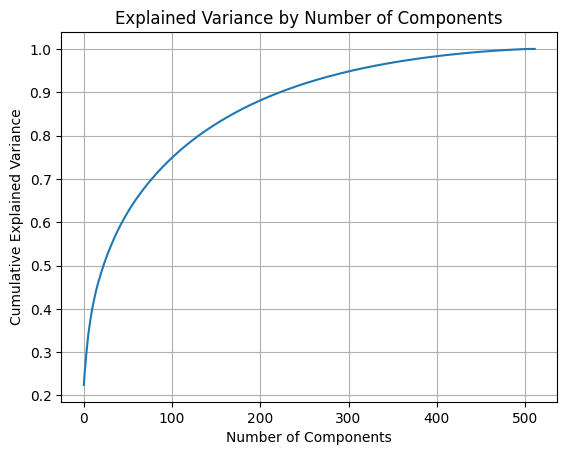

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming combined_features contains the extracted features from CLIP
# combined_features = ...

# Fit PCA and plot explained variance
pca = PCA().fit(combined_features)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()